In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from transformers import ViTForImageClassification, ViTFeatureExtractor, TrainingArguments, Trainer
from datasets import load_dataset, Dataset, DatasetDict
import os
import numpy as np

In [ ]:
dataset_name = "Team-SknAI/SknAI_300_v3_11Labels"  
datasets = load_dataset(dataset_name)

datasets

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3000
    })
})

In [3]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

c:\Users\vivek\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [4]:
feature_extractor.save_pretrained("./")

['./preprocessor_config.json']

In [5]:
datasets = datasets["train"].train_test_split(test_size=0.2)

In [6]:
datasets

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2400
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 600
    })
})

In [7]:
from PIL import Image

In [8]:
def transform_data(batch):
    images = []
    for img in batch["image"]:
        img = Image.fromarray(np.array(img).astype("uint8")) if not isinstance(img, Image.Image) else img
        img = img.convert("RGB")
        images.append(img)
    
    encodings = feature_extractor(images=images, return_tensors="pt")
    batch["pixel_values"] = encodings["pixel_values"].numpy()
    return batch

# Apply transformation using batched processing
datasets = datasets.map(transform_data, remove_columns=["image"], batched=True)

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

c:\Users\vivek\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\vivek\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Map:   0%|          | 0/600 [00:00<?, ? examples/s]

In [9]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k", 
    num_labels=len(datasets["train"].features["label"].names),
    id2label={i: label for i, label in enumerate(datasets["train"].features["label"].names)},
    label2id={label: i for i, label in enumerate(datasets["train"].features["label"].names)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
import torch

# device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [11]:
import evaluate

# Load accuracy metric
metric = evaluate.load("accuracy")

def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1),
        references=p.label_ids
    )

In [ ]:
training_args = TrainingArguments(
    output_dir="./SknAI_v5_11label",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    seed=42,
    evaluation_strategy="steps",
    num_train_epochs=20,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=0.0002,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,
    fp16=True,
)

c:\Users\vivek\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import get_scheduler
from torch.optim import Adam

def custom_optimizer(model):
    optimizer = Adam(model.parameters(), lr=0.0002, betas=(0.9, 0.999), eps=1e-08)
    
    # Define a Linear LR Scheduler
    scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=training_args.num_train_epochs * len(datasets['train']) // training_args.per_device_train_batch_size
    )
    
    return optimizer,scheduler

In [14]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [15]:
from transformers.data.data_collator import DefaultDataCollator
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=DefaultDataCollator(),
    train_dataset=datasets["train"],
    eval_dataset=datasets["test"],
    optimizers=custom_optimizer(model),
    compute_metrics=compute_metrics,
)

In [ ]:
train_results = trainer.train()
# save tokenizer with the model
trainer.save_model("./fine_tuned_SknAI_v5_11Label")
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
# save the trainer state
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,0.321800,0.449506,0.880000
200,0.208600,0.439759,0.865000
300,0.221800,0.388688,0.890000
400,0.044600,0.340043,0.901667
500,0.051500,0.392515,0.900000
600,0.022000,0.455772,0.896667
700,0.026600,0.431113,0.903333
800,0.015700,0.448110,0.903333
900,0.022000,0.483834,0.896667
1000,0.011800,0.499158,0.896667


***** train metrics *****
  epoch                    =         20.0
  total_flos               = 3464410270GF
  train_loss               =       0.1085
  train_runtime            =   1:22:15.91
  train_samples_per_second =        9.725
  train_steps_per_second   =        0.304


In [17]:
metrics = trainer.evaluate(datasets['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       20.0
  eval_accuracy           =     0.9017
  eval_loss               =       0.34
  eval_runtime            = 0:00:48.35
  eval_samples_per_second =     12.408
  eval_steps_per_second   =      0.786


In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

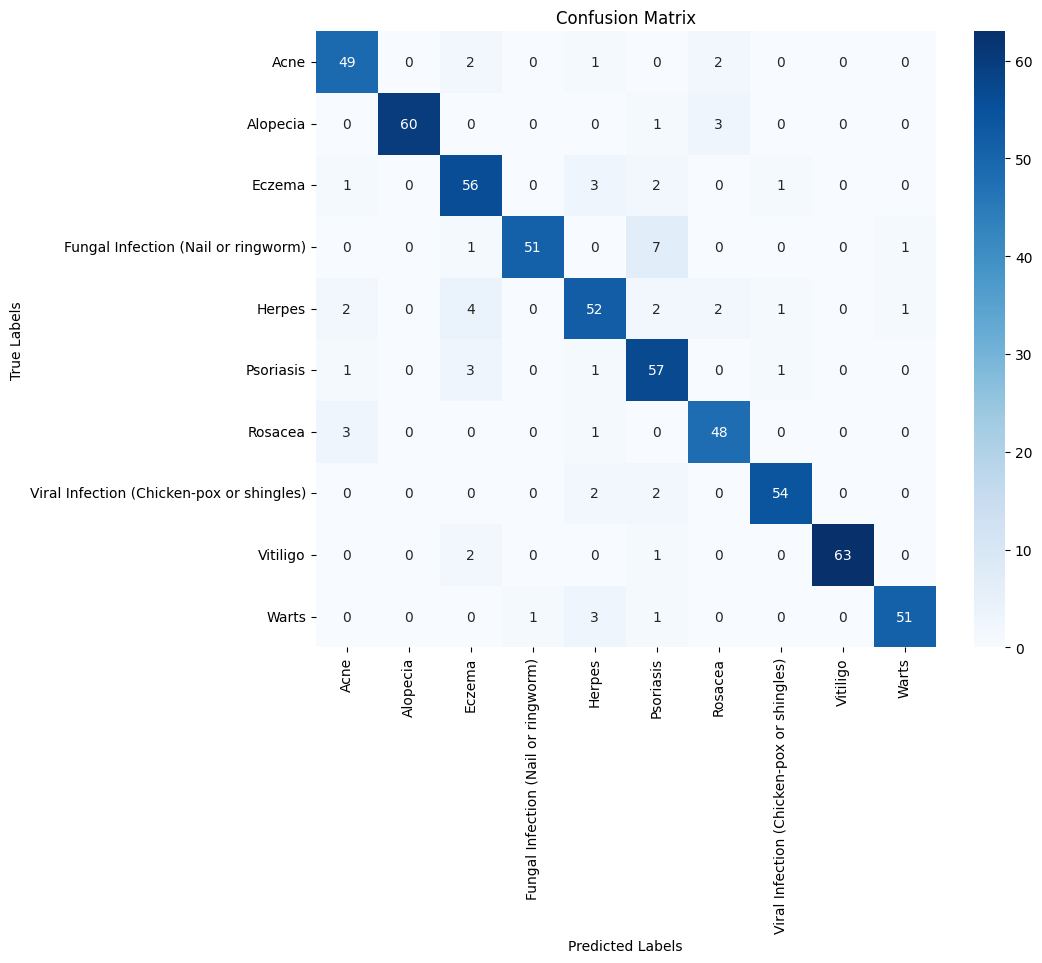

Classification Report:
                                           precision    recall  f1-score   support

                                     Acne       0.88      0.91      0.89        54
                                 Alopecia       1.00      0.94      0.97        64
                                   Eczema       0.82      0.89      0.85        63
      Fungal Infection (Nail or ringworm)       0.98      0.85      0.91        60
                                   Herpes       0.83      0.81      0.82        64
                                Psoriasis       0.78      0.90      0.84        63
                                  Rosacea       0.87      0.92      0.90        52
Viral Infection (Chicken-pox or shingles)       0.95      0.93      0.94        58
                                 Vitiligo       1.00      0.95      0.98        66
                                    Warts       0.96      0.91      0.94        56

                                 accuracy                     

In [19]:
predictions = trainer.predict(datasets["test"])
preds = np.argmax(predictions.predictions, axis=1)
labels = np.array(datasets["test"]["label"])

# Compute confusion matrix
conf_matrix = confusion_matrix(labels, preds)
class_names = list(model.config.id2label.values())

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(labels, preds, target_names=class_names))

In [20]:
import requests
from io import BytesIO


In [21]:
def predict_image(image_path_or_url, model, feature_extractor):
    model.eval()
    if image_path_or_url.startswith("http"):
        response = requests.get(image_path_or_url)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_path_or_url).convert("RGB")
    
    # Ensure the image is resized to match the expected input size
    image = image.resize((224, 224))
    inputs = feature_extractor(images=image, return_tensors="pt")
    
    # Ensure input matches model precision
    inputs = {k: v.to(model.dtype).to(model.device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=-1).item()
    class_name = model.config.id2label[predicted_class]
    print(f"Predicted class: {class_name}")
    return class_name


In [27]:
image_url = "./download.jpeg"
predict_image(image_url, model, feature_extractor)

Predicted class: Warts


'Warts'

In [2]:
from huggingface_hub import HfApi
api = HfApi()
api.create_repo("Team-SknAI/DenseNet121_v1")

api.upload_folder(
    folder_path="C:/Users/vivek/Desktop/SknAI Script/DenseNet_v1_10Label",
    repo_id="Team-SknAI/DenseNet121_v1"
)

best_model.pth:   0%|          | 0.00/30.6M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Team-SknAI/DenseNet121_v1/commit/b6a70975e275ad694e324d4eda3cdf1e2790e0b4', commit_message='Upload folder using huggingface_hub', commit_description='', oid='b6a70975e275ad694e324d4eda3cdf1e2790e0b4', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Team-SknAI/DenseNet121_v1', endpoint='https://huggingface.co', repo_type='model', repo_id='Team-SknAI/DenseNet121_v1'), pr_revision=None, pr_num=None)